## 1. Imports

**Pykrx 패키지를 활용해 SP500의 주식 데이터를 수집**  
코스피의 구성종목 중 2013-04-01~ 2023-04-31에 PER, PBR, DIV에 결측치가 존재하지 않는 주식에 대해 데이터를 수집  
총 186개의 종목에 대해 데이터를 수집
이후의 결과 비교를 위해 해당 종목의 수익률의 평균을 벤치마크로 삼기로 함

In [1]:
import FinanceDataReader as fdr
import pickle

import mybacktest as backtest # 자체 제작한 모듈

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from datetime import datetime
from time import time
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('data/krx_dict.pkl', 'rb') as f:
    kospi_dict = pickle.load(f)

In [3]:
tickers = kospi_dict['per'].columns.tolist()
len(tickers)

186

In [4]:
kospi_price = kospi_dict['price'][tickers]
kospi_cap = kospi_dict['cap'][tickers]
kospi_div = kospi_dict['div'][tickers]

In [5]:
for df in [kospi_price, kospi_cap, kospi_div]:
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

In [6]:
benchmark_return = kospi_price.pct_change().dropna().mean(axis=1)
benchmark_return

날짜
2013-04-02    0.001896
2013-04-03    0.003145
2013-04-04   -0.003133
2013-04-05   -0.009468
2013-04-08   -0.014628
                ...   
2023-03-27   -0.000318
2023-03-28    0.010125
2023-03-29    0.006841
2023-03-30    0.002581
2023-03-31    0.004119
Length: 2461, dtype: float64

## 2. 전략 수립 및 검증

### 2-1 개요

##### **고배당주가 저배당주에 비해 Outperform을 하는 지를 검증해보기로 함**    
배당수익률이 높은 주식을 매수, 낮은 주식을 매도,그 결과를 검증     
우선, 2013-04-01~ 2020-04-01까지의 기간을 대상으로 전략을 수립, 그 결과를 검증  
###### **만약, 결과가 안 좋을 시 다른 방식으로 전략을 수정**  

**cf) 백테스트 방식**  
각 날짜별로 보유 비중을 정하고, 해당 기간동안 각 자산을 전체자산 대비 정해진 비중만큼 매수 또는 매도.  
즉, 각 자산을(전체자산(현금+보유주식)* 비중) 매수 또는 매도(소수점 이하 버림).이 때, 현금에 대해서는  
매일 이자가 붙고, 매수/매도 시에는 수수료(commission)을, 매도시에는 세금(tax)를 추가로 납부.  
자세한 내용은 mybacktest 코드 참조  

In [7]:
start, end = "2013-04-01", "2020-04-01"

In [8]:
price_df = kospi_price[(kospi_price.index >= start) & (kospi_price.index <= end)]
price_df.head()

,005930,051910,005380,000270,005490,035420,003670,012330,105560,055550,...,078000,007590,000850,004450,069730,014440,026940,008420,123700,025530
날짜,,,,,,,,,,,,,,,,,,,,,
2013-04-01,30240.0,267500.0,222000.0,55100.0,325000.0,92287.0,11806.0,306000.0,37350.0,40600.0,...,9400.0,6390.0,45800.0,21100.0,3200.0,3125.0,2115.0,1705.0,9430.0,4830.0
2013-04-02,30500.0,259500.0,219500.0,55300.0,321500.0,90247.0,11834.0,306500.0,37300.0,39950.0,...,9440.0,6370.0,45150.0,21650.0,3190.0,3110.0,2090.0,1720.0,9170.0,4845.0
2013-04-03,30420.0,251000.0,218000.0,55100.0,323000.0,90247.0,11797.0,311000.0,37400.0,39850.0,...,9500.0,6250.0,45250.0,22200.0,3175.0,3060.0,2110.0,1740.0,9630.0,4850.0
2013-04-04,30120.0,245500.0,207000.0,53300.0,321000.0,89933.0,11694.0,301500.0,37000.0,39450.0,...,9480.0,6250.0,45150.0,22200.0,3160.0,3015.0,2100.0,1745.0,9620.0,4875.0
2013-04-05,30100.0,239000.0,198000.0,50800.0,312500.0,89776.0,11561.0,287000.0,36200.0,38800.0,...,9550.0,6330.0,43900.0,21750.0,3120.0,3130.0,2045.0,1735.0,9750.0,4860.0


### 2-2 전략 수립 및 검증(1) - 고배당(Long Short)

##### **배당수익률 상위 40개 매수, 하위 40개 매도**       
투자금액은 1,000,000,000원로 설정  
각 매수/매도하는 자산의 비중은 1/40로 정함  
거래비용은 수수료 0.015% (매수, 매도 시 모두 부여), 증권거래세 0.2% (매도 시에만 부여)  
이자율은 연 3%를 1일 단위로 바꾼 것으로 설정($(1+0.03)^{(1/252)}-1 $)  
리밸런싱 주기는 20영업일로 설정(20영업일 마다 비중 재조정)

##### **해당 기간의 누적수익률은 63.08%로 좋은 수익률을 보임(연간 7.42%)**   
##### **해당기간의 벤치마크 누적수익률은 24.75%(연간 3.29%)**    
test_factor를 활용해 각 분위별 Long Only Portfolio의 성과를 비교해 본 결과,  
5분위 Long-Only Portfolio가 가장 좋은 수익률을 보였고,샤프비율 MDD 모두에서도 가장 좋은 성과를 보임 

In [9]:
commission = 0.00015
tax = 0.002
interest = (1+0.03) ** (1/252) - 1
money = 1e9

In [10]:
factor_df = kospi_div[(kospi_div.index >= start) & (kospi_div.index <= end)]
factor_df.head()

,005930,051910,005380,000270,005490,035420,003670,012330,105560,055550,...,078000,007590,000850,004450,069730,014440,026940,008420,123700,025530
날짜,,,,,,,,,,,,,,,,,,,,,
2013-04-01,0.36,1.50,0.79,1.09,3.08,0.18,0.80,0.57,1.93,1.85,...,3.40,2.90,2.73,5.21,0.94,1.60,3.55,2.93,2.12,3.11
2013-04-02,0.36,1.54,0.80,1.08,3.11,0.19,0.79,0.57,1.93,1.88,...,3.39,2.90,2.77,5.08,0.94,1.61,3.59,2.91,2.18,3.10
2013-04-03,0.36,1.59,0.80,1.09,3.10,0.19,0.80,0.56,1.93,1.88,...,3.37,2.96,2.76,4.95,0.94,1.63,3.55,2.87,2.08,3.09
2013-04-04,0.37,1.63,0.85,1.13,3.12,0.19,0.80,0.58,1.95,1.90,...,3.38,2.96,2.77,4.95,0.95,1.66,3.57,2.87,2.08,3.08
2013-04-05,0.37,1.67,0.88,1.18,3.20,0.19,0.81,0.61,1.99,1.93,...,3.35,2.92,2.85,5.06,0.96,1.60,3.67,2.88,2.05,3.09


In [11]:
rebalance_period=20
rebalance_dates = factor_df.index[::rebalance_period].tolist()

In [12]:
signal = backtest.generate_signal_using_factor(factor_df, n_positions=40,
                                               long_min=-np.inf, short_max=np.inf, long_short=True)

In [13]:
weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=40,
                                                              n_min_positions=0, long_short=True)

In [14]:
daily_return= backtest.backtest_from_weights(price_df, weights, money,
                                            rebalance_dates, commission, tax, interest)

In [15]:
cumulative_return = backtest.calculate_cumulative_return(daily_return)
cumulative_return

2013-04-01   -0.002071
2013-04-02   -0.002279
2013-04-03   -0.006029
2013-04-04   -0.009147
2013-04-05   -0.013558
                ...   
2020-03-26    0.668995
2020-03-27    0.682447
2020-03-30    0.677827
2020-03-31    0.646505
2020-04-01    0.630821
Length: 1721, dtype: float64

In [16]:
benchmark_return = benchmark_return[(benchmark_return.index >= daily_return.index[0]) & 
                            (benchmark_return.index <= daily_return.index[-1])]

In [17]:
benchmark_cumulative_return = backtest.calculate_cumulative_return(benchmark_return)
benchmark_cumulative_return

날짜
2013-04-02    0.001896
2013-04-03    0.005047
2013-04-04    0.001898
2013-04-05   -0.007588
2013-04-08   -0.022105
                ...   
2020-03-26    0.184729
2020-03-27    0.209630
2020-03-30    0.225330
2020-03-31    0.265535
2020-04-01    0.247495
Length: 1720, dtype: float64

In [18]:
summary_stats = backtest.summary_stats(daily_return,rf=0, alpha=0.05, min_return=0, year=252, benchmark=benchmark_return)
summary_stats

,Portfolio,Benchmark
Cumulative Return,63.08%,24.75%
Annualized Return,7.42%,3.29%
Annualized Std,11.46%,13.37%
Annualized Sharpe,68.23%,30.98%
MDD,-15.58%,-43.61%
Var,-11.43%,-18.70%
C_Var,-16.22%,-24.28%
Shortfall Prob(min_return=0.00%),25.86%,40.27%


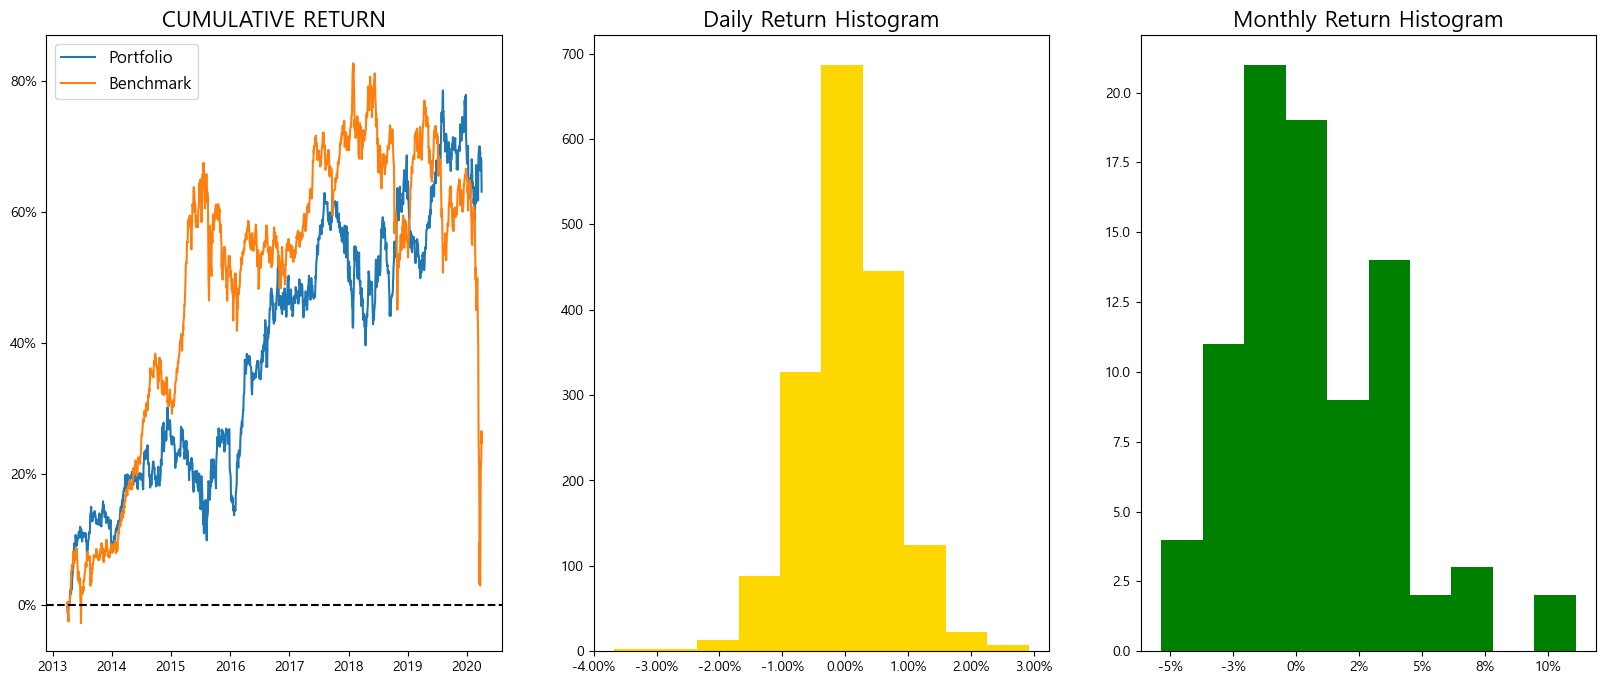

In [19]:
backtest.plot_return(daily_return, benchmark_return)

In [20]:
factor_test = backtest.test_factor(5, price_df, factor_df, money, rebalance_dates, 
                                   commission, interest, tax)
factor_test

,Q1,Q2,Q3,Q4,Q5
Annualized_return,-0.009319,0.039065,0.003752,0.022700,0.058342
Annualized_std,0.167738,0.155531,0.140873,0.134734,0.115480
Annualized_sharpe,0.028628,0.324721,0.097425,0.234640,0.549148
MDD,-0.532621,-0.454486,-0.474289,-0.481750,-0.378012


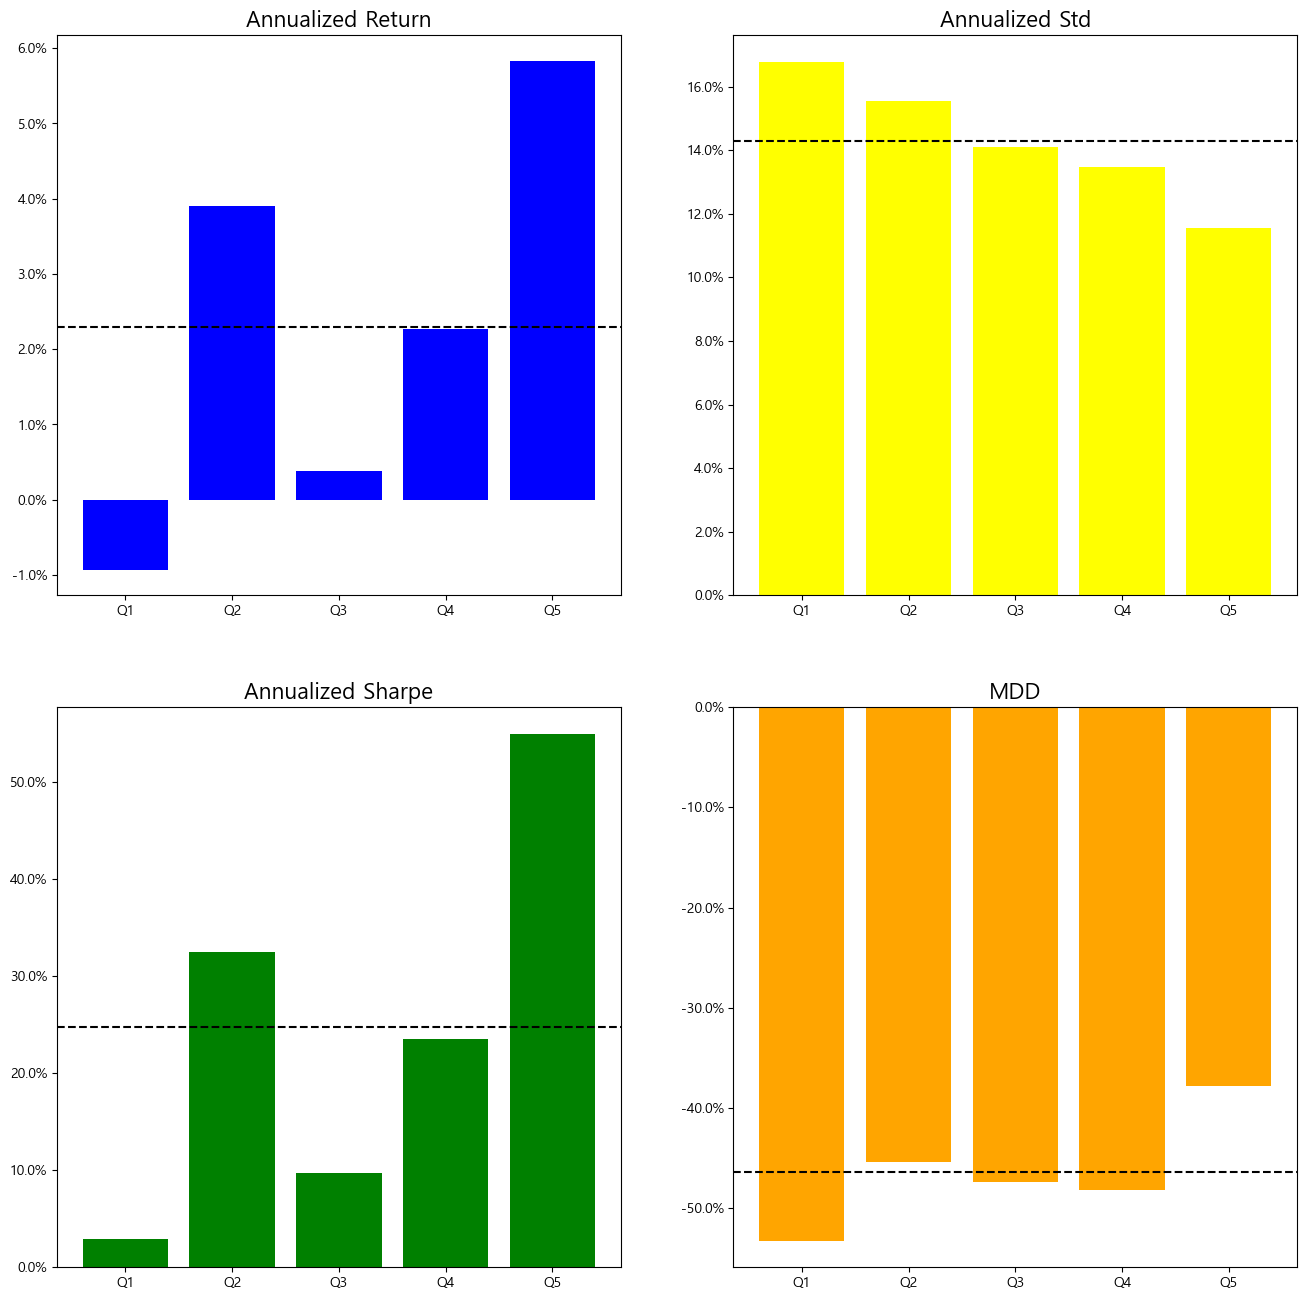

In [21]:
backtest.plot_factor_test_result(5, price_df, factor_df, money, rebalance_dates, commission,
                                interest, tax)

## 3. 전략 최적화 및 추가 분석

### 3-1 전략 최적화

##### 2-2의 전략을 수정해서 보다 더 좋은 성과를 내는 전략을 찾고자 함    
롱숏 중 어떤 것이 나을 지 결정하고, 리밸런싱 주기을  20일, 40일,  60일, 80일, 100일 등으로 변경   
비중설정방식도 동일가중방식과 시가총액가중방식 등으로 변경   
샤프비율을 기준으로 순위를 매겨 봄   
전체적인 방식은 2-2과 동일

##### 다양한 전략들을 샤프비율을 기준으로 테스트해본 결과, 
##### 20일  단위로 리밸런싱, 동일가중방식이 가장 적합할 것으로 보여짐 
(다만 성과가 상위 전략들은 성과가 크게 차이난다고 보기는 어려울 것 같다)  

In [22]:
cap_df = kospi_cap[(kospi_cap.index >= start) & (kospi_cap.index <= end)]
factor_df = kospi_div[(kospi_div.index >= start) & (kospi_div.index <= end)]

In [23]:
invests = [True, False]
rebalance_periods = [20, 40, 60, 80, 100]
set_weights = ['equal', 'market_cap']
result_df = []
for rebalance_period in rebalance_periods:
    for set_weight in set_weights:
        for invest in invests:
            long_short=invest
            rebalance_dates = factor_df.index[::rebalance_period].tolist()
            signal = backtest.generate_signal_using_factor(factor_df, n_positions=40,
                                               long_min=-np.inf, short_max=np.inf, long_short=long_short)
            if set_weight == 'equal':
                weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=40,
                                                                              n_min_positions=0, long_short=long_short)
            else:
                weights = backtest.generate_cap_weight_portfolio_from_signal(signal, n_positions=40,
                                                              n_min_positions=0, cap=cap_df, long_short=long_short)
            daily_return = backtest.backtest_from_weights(price_df, weights, money,
                                        rebalance_dates, commission, tax, interest)
            annualized_return = backtest.annualize_return(daily_return)
            annualized_sharpe = backtest.annualize_sharpe(daily_return)
            result_df.append([invest, rebalance_period, set_weight, annualized_return, annualized_sharpe])
opt_df = pd.DataFrame(result_df, columns=['long_short','rebalance_period', 'set_weight',
                                          'annualized_return', 'annualized_sharpe'])
opt_df = opt_df.sort_values(by='annualized_sharpe', ascending=False)
opt_df = opt_df.reset_index(drop=True)
opt_df.head(5)

,long_short,rebalance_period,set_weight,annualized_return,annualized_sharpe
0,True,20,equal,0.074241,0.682261
1,True,40,equal,0.074640,0.676096
2,True,100,equal,0.073025,0.653991
3,True,80,equal,0.065359,0.605294
4,True,60,equal,0.056910,0.524206


##### 롱숏, 20일  단위로 리밸런싱, 동일가중방식

In [24]:
signal = backtest.generate_signal_using_factor(factor_df, n_positions=40,
                                               long_min=-np.inf, short_max=np.inf, long_short=True)
rebalance_period=20
rebalance_dates = factor_df.index[::rebalance_period].tolist()
weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=40,
                                                               n_min_positions=0, long_short=True)
daily_return= backtest.backtest_from_weights(price_df, weights, money,
                                            rebalance_dates, commission, tax, interest)

In [25]:
summary_stats = backtest.summary_stats(daily_return,rf=0, alpha=0.05, min_return=0, year=252, benchmark=benchmark_return)
summary_stats

,Portfolio,Benchmark
Cumulative Return,63.08%,24.75%
Annualized Return,7.42%,3.29%
Annualized Std,11.46%,13.37%
Annualized Sharpe,68.23%,30.98%
MDD,-15.58%,-43.61%
Var,-11.43%,-18.70%
C_Var,-16.22%,-24.28%
Shortfall Prob(min_return=0.00%),25.86%,40.27%


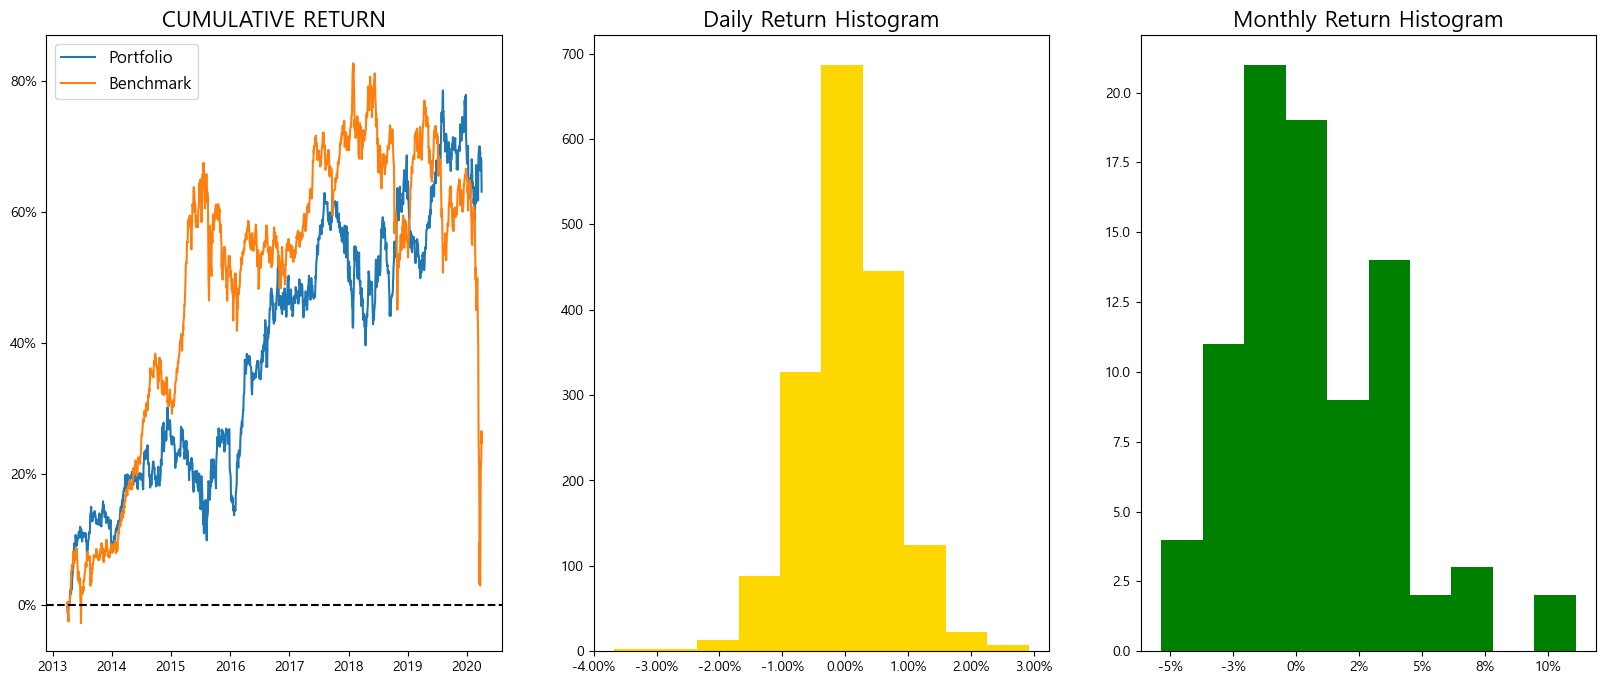

In [26]:
backtest.plot_return(daily_return, benchmark=benchmark_return)

### 3-2 추가분석

#####  Pyfolio, Quantstats 등의 Package를 활용해 보다 추가적인 분석을 진행하기로 함
Benchmark에 비해서 지속적으로 좋은 모습을 보여주지는 못했지만  
벤치마크가 급락하는 구간에서도 수익률이 크게 떨어지지 않는 모습을 보임  
전체적으로 안정적으로 수익을 내는 모습을 보인 점이 인상적(MDD - 15.5%)  

In [27]:
import pyfolio as pf
import quantstats as qs
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe

In [28]:
daily_return = daily_return[daily_return.index >= benchmark_return.index[0]]

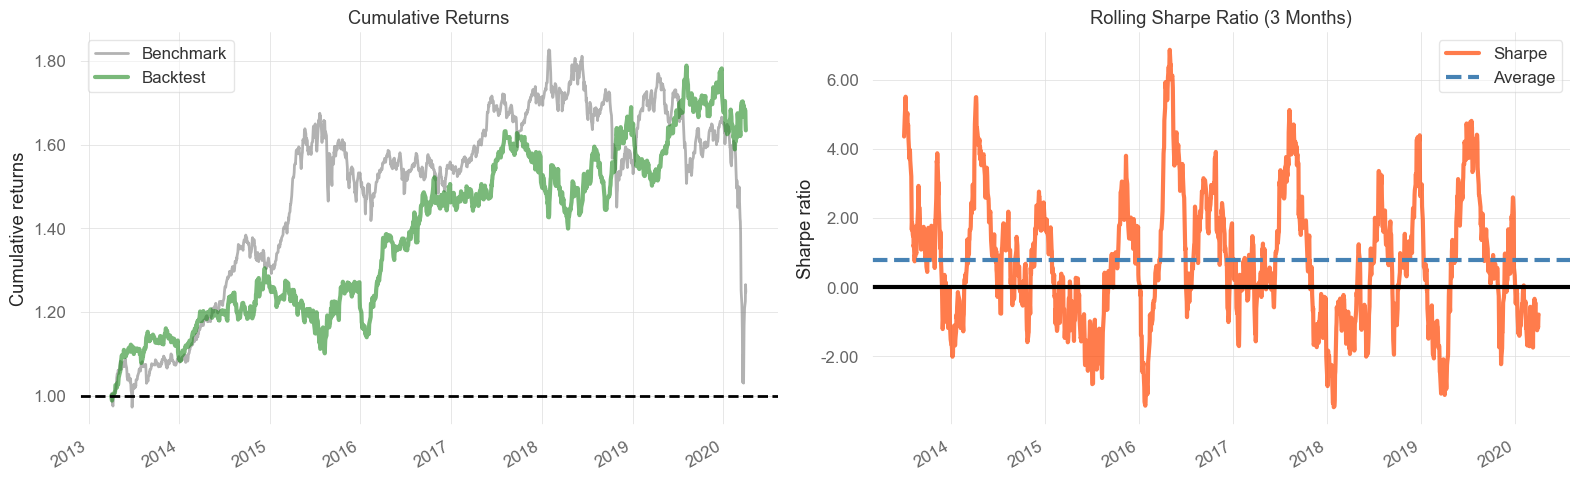

In [29]:
benchmark_return.name='Benchmark'
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(daily_return,
                     factor_returns=benchmark_return,
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(daily_return, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
sns.despine()
fig.tight_layout()

Start date,2013-04-02
End date,2020-04-01
Total months,81
,Backtest
Annual return,7.461%
Cumulative returns,63.421%
Annual volatility,11.464%
Sharpe ratio,0.69
Calmar ratio,0.48
Stability,0.90
Max drawdown,-15.579%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.58,2014-12-11,2015-08-10,2016-03-24,336
1,14.26,2017-08-07,2018-04-16,2018-10-29,321
2,11.19,2019-08-06,2020-02-17,NaT,NaN
3,11.11,2018-12-26,2019-03-20,2019-07-09,140
4,6.69,2013-11-08,2014-01-06,2014-03-10,87


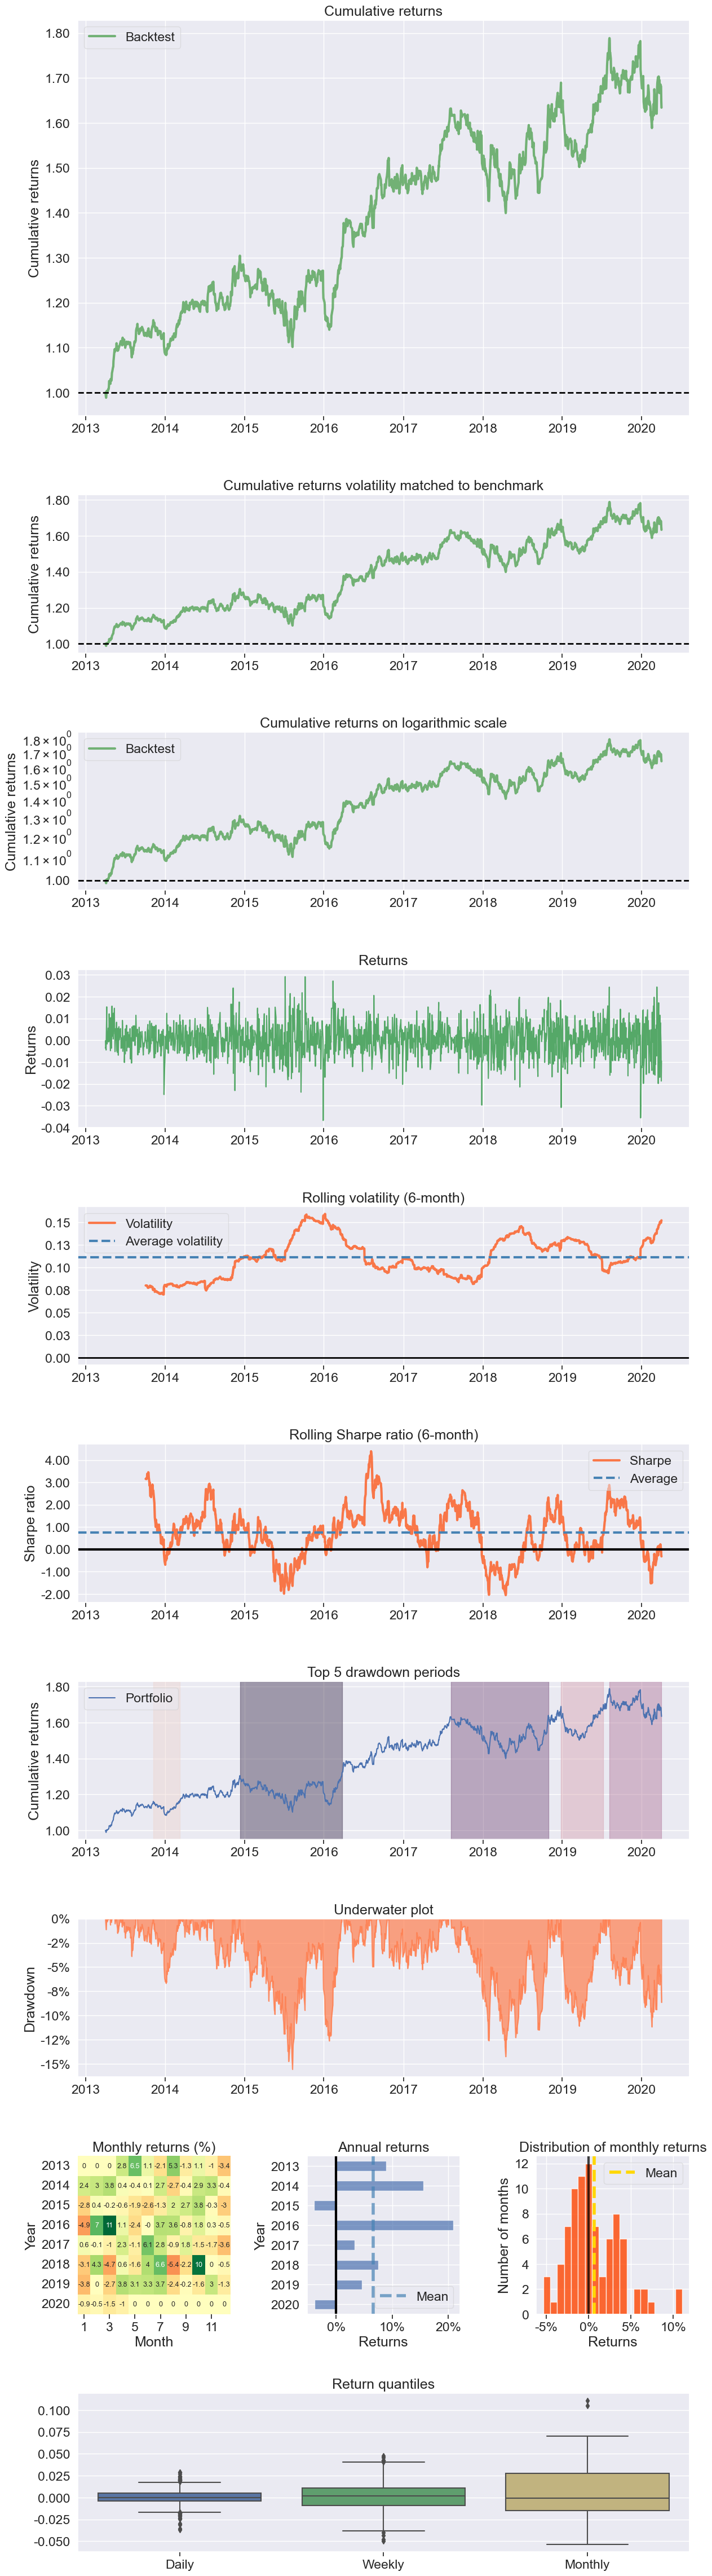

In [30]:
pf.create_returns_tear_sheet(daily_return)

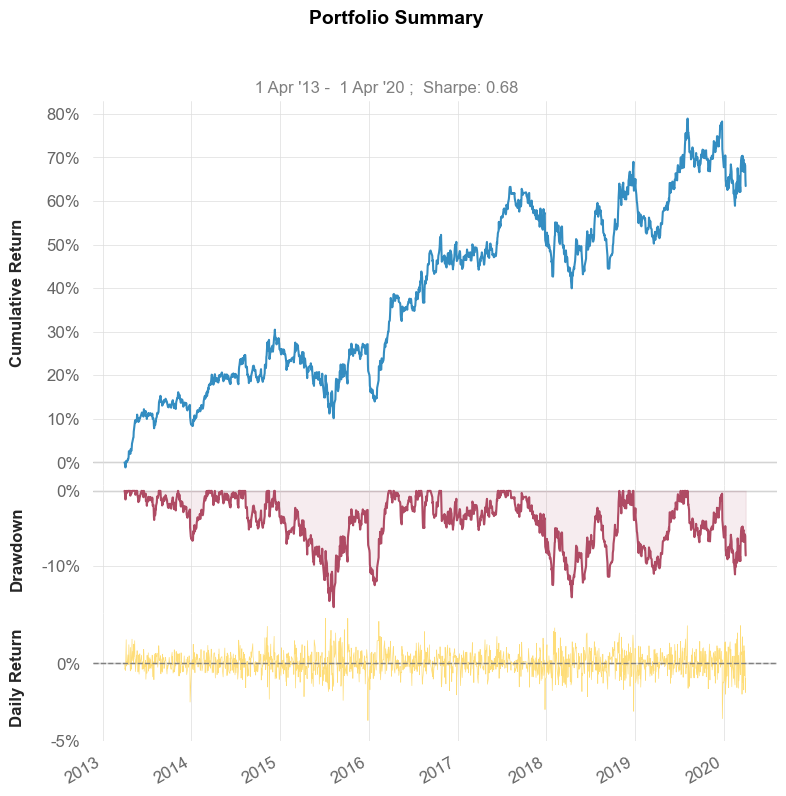

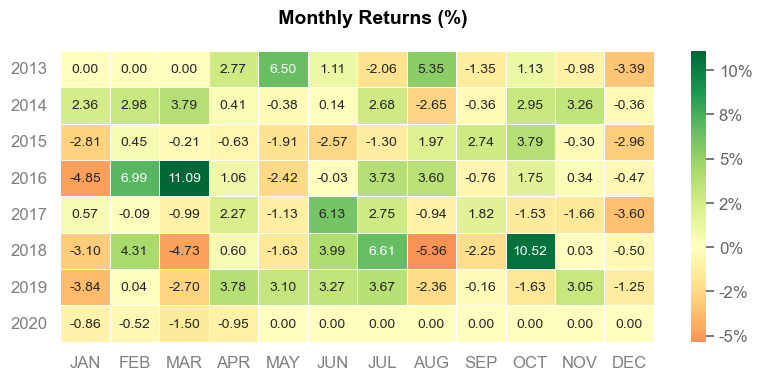

In [31]:
qs.reports.plots(daily_return, mode='basic')

In [32]:
qs.reports.metrics(daily_return, benchmark=benchmark_return, mode='basic')

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2013-04-02  2013-04-02
End Period          2020-04-01  2020-04-01
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   63.42%      24.75%
CAGR﹪              7.27%       3.21%

Sharpe              0.69        0.31
Prob. Sharpe Ratio  96.28%      78.73%
Sortino             0.99        0.4
Sortino/√2          0.7         0.28
Omega               1.12        1.12

Max Drawdown        -15.58%     -43.61%
Longest DD Days     468         792

Gain/Pain Ratio     0.12        0.06
Gain/Pain (1M)      0.72        0.28

Payoff Ratio        0.89        0.78
Profit Factor       1.12        1.06
Common Sense Ratio  1.14        0.87
CPC Index           0.51        0.48
Tail Ratio          1.02        0.81
Outlier Win Ratio   3.05        3.51
Outlier Loss Ratio  4.14        3.53

MTD                 -0.95%      -1.43%
3M                  -3.79%      -24.

### 3-3 다른 기간에 대한 검증

##### 2022-04-01~2023-04-01까지의 기간에 대해 해당전략을 적용하고, 성과를 평가

##### **해당 기간의 누적수익률은 3.89%의수익률을 보임(연간 1.31%)**    
##### **해당기간의 벤치마크누적수익률은 86.30%(연간 23.53%)**      
##### **벤치마크에 비해 좋지 못한 성과를 보임**

In [33]:
start, end = "2020-04-01", "2023-04-01"

price_df = kospi_price[(kospi_price.index >= start) & (kospi_price.index <= end)]
factor_df = kospi_div[(kospi_div.index >= start) & (kospi_div.index <= end)] 

In [34]:
benchmark_return = kospi_price.pct_change().dropna().mean(axis=1)
benchmark_return = benchmark_return[(benchmark_return.index >= start) & (benchmark_return.index <= end)]

In [35]:
rebalance_period = 20
rebalance_dates = factor_df.index[::rebalance_period].tolist()
signal = backtest.generate_signal_using_factor(factor_df, n_positions=40,
                                               long_min=-np.inf, short_max=np.inf, long_short=True)
weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=40,
                                                              n_min_positions=0, long_short=True)
daily_return= backtest.backtest_from_weights(price_df, weights, money,
                                            rebalance_dates, commission, tax, interest)

In [36]:
factor_test = backtest.test_factor(5, price_df, factor_df, money, rebalance_dates, 
                                   commission, interest, tax)
factor_test

,Q1,Q2,Q3,Q4,Q5
Annualized_return,0.186568,0.266548,0.253972,0.239430,0.216289
Annualized_std,0.201149,0.200395,0.184015,0.159751,0.155288
Annualized_sharpe,0.951459,1.280126,1.322627,1.424269,1.339176
MDD,-0.356542,-0.280501,-0.251567,-0.194054,-0.190127


In [37]:
summary_stats = backtest.summary_stats(daily_return,rf=0, alpha=0.05, min_return=0, year=252, benchmark=benchmark_return)
summary_stats

,Portfolio,Benchmark
Cumulative Return,3.89%,86.30%
Annualized Return,1.31%,23.53%
Annualized Std,15.07%,16.65%
Annualized Sharpe,16.17%,135.34%
MDD,-29.31%,-22.73%
Var,-23.49%,-3.85%
C_Var,-29.79%,-10.81%
Shortfall Prob(min_return=0.00%),46.55%,7.88%


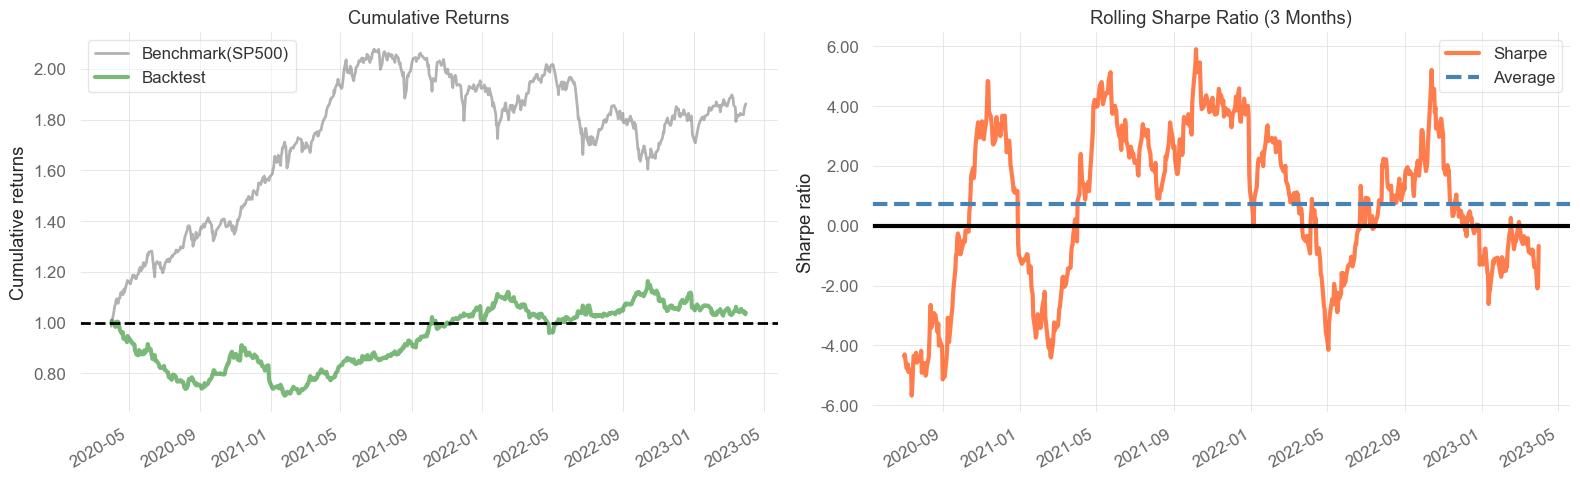

In [38]:
benchmark_return.name='Benchmark(SP500)'
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(daily_return,
                     factor_returns=benchmark_return,
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(daily_return, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
sns.despine()
fig.tight_layout()

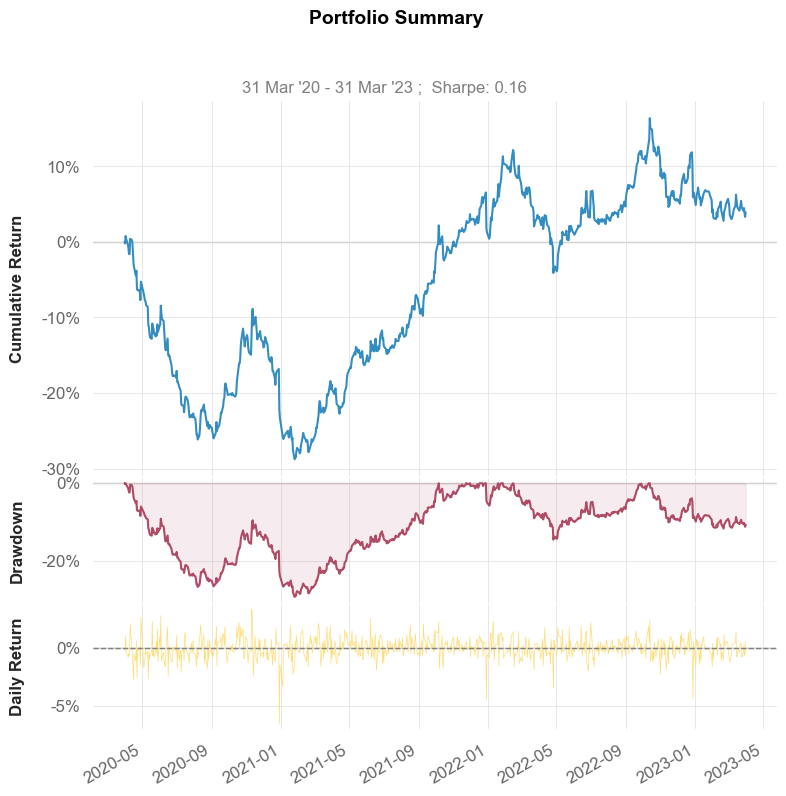

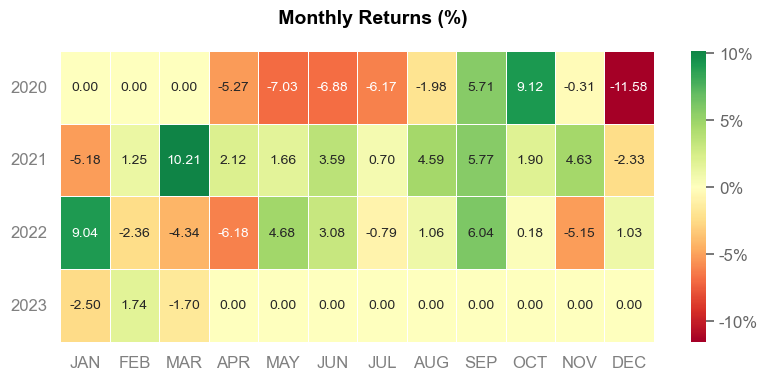

In [39]:
qs.reports.plots(daily_return, mode='basic')

In [40]:
qs.reports.metrics(daily_return, benchmark=benchmark_return, mode='basic')

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2020-04-01  2020-04-01
End Period          2023-03-31  2023-03-31
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   3.89%       86.3%
CAGR﹪              1.28%       23.07%

Sharpe              0.16        1.35
Prob. Sharpe Ratio  60.89%      98.81%
Sortino             0.22        1.88
Sortino/√2          0.16        1.33
Omega               1.03        1.03

Max Drawdown        -29.31%     -22.73%
Longest DD Days     551         640

Gain/Pain Ratio     0.03        0.25
Gain/Pain (1M)      0.1         1.2

Payoff Ratio        0.86        1.08
Profit Factor       1.03        1.25
Common Sense Ratio  1.13        1.09
CPC Index           0.45        0.79
Tail Ratio          1.1         0.87
Outlier Win Ratio   3.3         3.11
Outlier Loss Ratio  3.97        3.25

MTD                 -1.7%       0.04%
3M                  -2.49%      7.02%

##### **Cf) Long Only 전략**

Long Only로 전략을 수정할 경우, 78.84%의 수익률을 보임(연간 21.83%)  
전략 수립시에도 Long-Short과 Long Only의 전략의 차이가 아주 크지는 않았기 때문에  
Long Only 전략을 쓰는 것도 좋을 듯 하다  

In [41]:
rebalance_period = 20
rebalance_dates = factor_df.index[::rebalance_period].tolist()
signal = backtest.generate_signal_using_factor(factor_df, n_positions=40,
                                               long_min=-np.inf, short_max=np.inf, long_short=False)
weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=40,
                                                              n_min_positions=0, long_short=False)
daily_return= backtest.backtest_from_weights(price_df, weights, money,
                                            rebalance_dates, commission, tax, interest)

In [42]:
summary_stats = backtest.summary_stats(daily_return,rf=0, alpha=0.05, min_return=0, year=252, benchmark=benchmark_return)
summary_stats

,Portfolio,Benchmark
Cumulative Return,78.84%,86.30%
Annualized Return,21.83%,23.53%
Annualized Std,15.35%,16.65%
Annualized Sharpe,136.37%,135.34%
MDD,-18.37%,-22.73%
Var,-3.42%,-3.85%
C_Var,-9.83%,-10.81%
Shortfall Prob(min_return=0.00%),7.75%,7.88%
